# Fully Connected neural Networks

### Benötigte imports

In [1]:
import keras as keras
import numpy as np
import tensorflow as tf
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.python.eager import context
from tensorflow.keras.utils import plot_model
from keras.models import clone_model
from keras.optimizers import Adam, SGD
import matplotlib.ticker as ticker

import matplotlib.pyplot as plt
import random

## Digit Recognition

### Erstellung des Modells

In [2]:
# initialisierung des Modells
untrained_model = Sequential()
untrained_model.add(Dense(600, activation='relu', input_shape=(784, ),name = "first_layer"))
untrained_model.add(Dense(400, activation='relu',  name = "hidden_layer_1"))
untrained_model.add(Dense(100, activation='relu',  name = "hidden_layer_2"))
untrained_model.add(Dense(10, activation = 'softmax', name = "output_layer"))

### Erstelltes Modell kompilieren

In [3]:
# kompilieren des Modells
model = clone_model(untrained_model)


optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Einlesen der Trainingsdaten

In [4]:
import random
from keras.datasets import mnist
import sys

# Diese Methode ließt eine Anzahl von train_size Handgeschriebenen Ziffern zum Training und eine Anzahl von
# test_size Hangeschriebenen Ziffern zum Testen aus dem  mnist dataset in arrays und gibt die arrays zurück
import inspect
print(inspect.getsource(mnist.load_data))
def readData(train_size, test_size):
    # Lade den MNIST-Datensatz
    data=np.load("mnist.npz")
    x_train=data['x_train']
    y_train=data['y_train']
    x_test=data['x_test']
    y_test=data['y_test']
    #(x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Überprüfe, ob train_size oder test_size nicht größer als die Anzahl der Datensätze ist
    if train_size > len(x_train) :
        print("Fehler: train_size überschreitet Datenmenge von "+str(len(x_train)))
        sys.exit() 
    if test_size > len(x_test) :
        print("Fehler: test_size überschreitet Datenmenge von "+str(len(x_test)))
        sys.exit() 

    # Wähle zufällige Indizes für Trainingsdaten
    train_indices = random.sample(range(len(x_train)), train_size)
    # Wähle zufällige Indizes für Testdaten
    test_indices = random.sample(range(len(x_test)), test_size)
    
    # Extrahiere die ausgewählten Trainingsdaten und Testdaten
    train_data = x_train[train_indices].reshape(train_size, -1) / 255.0
    verify_train_data = y_train[train_indices]
    test_data = x_test[test_indices].reshape(test_size, -1) / 255.0
    verify_test_data = y_test[test_indices]

    return train_data, verify_train_data, test_data, verify_test_data

@keras_export("keras.datasets.mnist.load_data")
def load_data(path="mnist.npz"):
    """Loads the MNIST dataset.

    This is a dataset of 60,000 28x28 grayscale images of the 10 digits,
    along with a test set of 10,000 images.
    More info can be found at the
    [MNIST homepage](http://yann.lecun.com/exdb/mnist/).

    Args:
      path: path where to cache the dataset locally
        (relative to `~/.keras/datasets`).

    Returns:
      Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.

    **x_train**: uint8 NumPy array of grayscale image data with shapes
      `(60000, 28, 28)`, containing the training data. Pixel values range
      from 0 to 255.

    **y_train**: uint8 NumPy array of digit labels (integers in range 0-9)
      with shape `(60000,)` for the training data.

    **x_test**: uint8 NumPy array of grayscale image data with shapes
      (10000, 28, 28), containing the test data. Pixel values range
      from 0 to 255.

    **y_test**: uint8 NumPy array 

In [5]:
# importiere callback Klasse um benutzerdefinierte Aktionen während des Trainings des Modells durchführen zu können
from keras.callbacks import Callback

# erstelle Klasse mit benutzerdefinierten Aktionen, die während des trainings ausgeführt werden sollen
class TrainMetricsCallback(Callback):
    def __init__(self, x_test=None, y_test=None):
        super(TrainMetricsCallback, self).__init__()
        # listen zum speichern der accuracy und losses auf dem Test und dem Trainingsdatenset nach jeder epoch
        self.train_losses = []
        self.train_accuracies = []
        self.test_losses = []
        self.test_accuracies = []
        self.x_test = x_test
        self.y_test = y_test

    # Am ende der epoch füge die accuracy und loss werte zu den Listen hinzu
    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.train_accuracies.append(logs.get('accuracy'))
        
        if self.x_test is not None and self.y_test is not None:
            # Auswerten der modells für das Trainigsdatenset
            loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
            self.test_losses.append(loss)
            self.test_accuracies.append(accuracy)

# Methode um nach jdem Trainingsschritt die accuracy und loss sowohl auf dem Testdatenset als auch
# auf den Trainingsdatenset als Liste zurückzugeben
def train_and_get_metrics(model, x_train, y_train, x_test=None, y_test=None, epochs=1, batch_size = 128):
    train_metrics_callback = TrainMetricsCallback(x_test, y_test)
    model.fit(x_train, y_train, epochs=epochs, callbacks=[train_metrics_callback],  batch_size=batch_size)
    
    # geben die accuracies und losses für die Test und Trainingsdaten zurück
    return train_metrics_callback.train_losses, train_metrics_callback.train_accuracies, \
           train_metrics_callback.test_losses, train_metrics_callback.test_accuracies, model


In [6]:
# Einlesen der Trainingsdaten und Testdaten
train_length = 200
test_length = 10000
epoch=17
train_data, train_verification_data, test_data, test_verification_data = readData(train_length, test_length)

### Training des Modells

In [7]:
# Trainieren des Modells
train_losses, train_accuracies,test_losses, test_accuracies, model = train_and_get_metrics(model, train_data, train_verification_data, test_data, test_verification_data,  epochs=epoch, batch_size=128)

Epoch 1/17
2/2 [==============================] - 1s 644ms/step - loss: 2.3021 - accuracy: 0.1300
Epoch 2/17
2/2 [==============================] - 1s 542ms/step - loss: 1.8404 - accuracy: 0.5150
Epoch 3/17
2/2 [==============================] - 1s 537ms/step - loss: 1.3727 - accuracy: 0.7050
Epoch 4/17
2/2 [==============================] - 1s 521ms/step - loss: 0.9300 - accuracy: 0.9100
Epoch 5/17
2/2 [==============================] - 1s 542ms/step - loss: 0.5985 - accuracy: 0.9250
Epoch 6/17
2/2 [==============================] - 1s 562ms/step - loss: 0.3594 - accuracy: 0.9450
Epoch 7/17
2/2 [==============================] - 1s 546ms/step - loss: 0.2396 - accuracy: 0.9500
Epoch 8/17
2/2 [==============================] - 1s 521ms/step - loss: 0.1418 - accuracy: 0.9750
Epoch 9/17
2/2 [==============================] - 1s 526ms/step - loss: 0.0967 - accuracy: 0.9800
Epoch 10/17
2/2 [==============================] - 1s 524ms/step - loss: 0.0666 - accuracy: 0.9850
Epoch 11/17
2/2 [==

### Testen und plotten

In [8]:
# Konvertiert das 1D-Array in ein 2D-Array, das zum Plotten der Ziffer verwendet wird.
def to2DArray(vektor):
    matrix = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            matrix[i, j] = vektor[i*28 + j]
            
    return matrix

def predictAndPlotAndShowOutput(modell, testdaten, test_verifikationsdaten, label=False):
    ziffern_verfügbar = range(len(testdaten))
    ziffern_zum_plotten = np.random.choice(ziffern_verfügbar, size = 6, replace=False)
    if label:
        fig, ax = plt.subplots(3, 4, figsize=(12, 12))
    else:
        fig, ax = plt.subplots(3, 4, figsize=(12, 9))
    for j in range(3):
        for i in range(2):
            vorhersage = modell.predict(np.array([testdaten[ziffern_zum_plotten[j*2+i]]]))
            geratene_ziffer = np.argmax(vorhersage)
            confidence = np.max(vorhersage)
            ax[j, 2*i].imshow(to2DArray(testdaten[ziffern_zum_plotten[j*2+i]]), cmap='gray', interpolation='none')
            #+ ", confidence: " +str(round(confidence,3)))
            ax[j, 2*i].axes.get_xaxis().set_visible(False)
            ax[j, 2*i].axes.get_yaxis().set_visible(False)
            ax[j, 2*i+1].bar(np.arange(10), vorhersage[0], color = 'navy')
            
            ax[j, 2*i+1].set_ylabel("Probability")
            ax[j, 2*i+1].set_ylim(0,1)
            ax[j, 2*i+1].set_title("Output")

            if label:
                ax[j, 2*i+1].set_xticks(np.arange(10))
                ax[j, 2*i+1].set_xticklabels(label,rotation = 75)
                ax[j, 2*i].set_title("Prediction: "+label[geratene_ziffer])
            else:
                ax[j, 2*i].set_title("Prediction: "+str(geratene_ziffer))
                ax[j, 2*i+1].set_xticks(np.arange(10))
                ax[j, 2*i+1].set_xlabel("Digit")
    if label:
        plt.subplots_adjust(hspace=0.4, wspace=0.3)

  
    plt.tight_layout()
    plt.savefig("output.png", dpi=500)
    
    plt.subplots_adjust(hspace=0.4, wspace = 0.3)

1/1 [==============================] - 0s 14ms/step


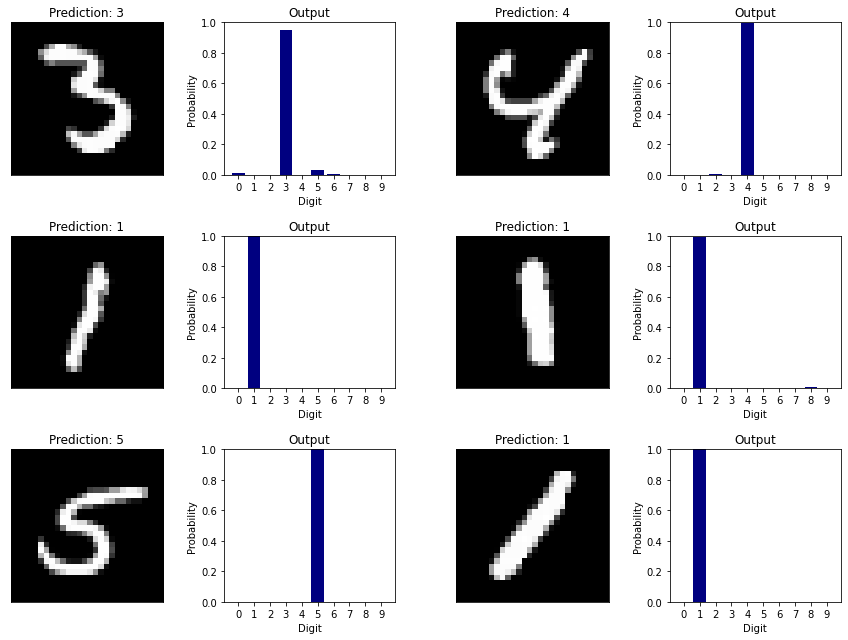

In [9]:
predictAndPlotAndShowOutput(model, test_data, test_verification_data)

### Trainingsverlauf

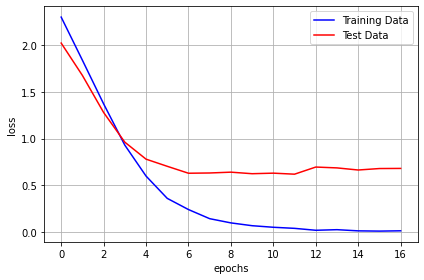

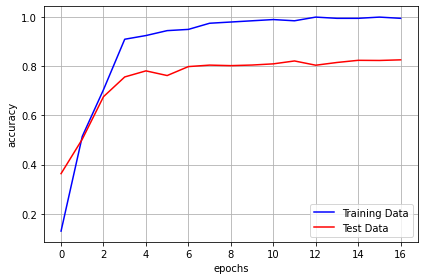

In [10]:
# plotten
epochs = np.arange(epoch)
plt.plot(epochs, train_losses, label = 'Training Data', color ='blue')
plt.plot(epochs, test_losses, label = 'Test Data', color ='red')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(epochs, train_accuracies, label = 'Training Data', color ='blue')
plt.plot(epochs, test_accuracies, label = 'Test Data', color ='red')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Fashion Recognition

### Daten Laden

In [11]:
def load_mnist(kind='train', model_type ='convolutional'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(os.getcwd(),
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(os.getcwd(),
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
    if model_type == 'convolutional':
        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                                offset=16).reshape(len(labels), 28, 28)#.reshape(len(labels), 784)
    elif model_type == 'fully_connected':
        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

### Lade Fashion Daten

In [12]:
x_train_full_connected, y_train_full_connected = load_mnist(kind='train', model_type ='fully_connected')
x_test_full_connected, y_test_full_connected = load_mnist(kind='t10k', model_type ='fully_connected')
x_train_full_connected = np.expand_dims(x_train_full_connected, -1)
x_test_full_connected = np.expand_dims(x_test_full_connected, -1)

### Neues Modell erstellen (clonen) und trainieren

In [13]:
modelFullyConnected = clone_model(untrained_model)
optimizer = Adam(learning_rate=0.001)
modelFullyConnected.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_losses_fully_con, train_accuracies_fully_con, test_losses_fully_con, test_accuracies_fully_con, modelFullyConnected = train_and_get_metrics(modelFullyConnected, x_train_full_connected[:200], y_train_full_connected[:200], x_test_full_connected, y_test_full_connected,  epochs=17,  batch_size=128)

Epoch 1/17
2/2 [==============================] - 1s 645ms/step - loss: 152.4102 - accuracy: 0.1600
Epoch 2/17
2/2 [==============================] - 1s 570ms/step - loss: 124.9623 - accuracy: 0.2050
Epoch 3/17
2/2 [==============================] - 1s 553ms/step - loss: 67.5279 - accuracy: 0.4050
Epoch 4/17
2/2 [==============================] - 1s 575ms/step - loss: 34.5418 - accuracy: 0.4250
Epoch 5/17
2/2 [==============================] - 1s 575ms/step - loss: 14.5848 - accuracy: 0.5550
Epoch 6/17
2/2 [==============================] - 1s 559ms/step - loss: 12.2925 - accuracy: 0.5750
Epoch 7/17
2/2 [==============================] - 1s 547ms/step - loss: 8.2967 - accuracy: 0.6350
Epoch 8/17
2/2 [==============================] - 1s 562ms/step - loss: 5.2599 - accuracy: 0.7350
Epoch 9/17
2/2 [==============================] - 1s 570ms/step - loss: 6.5006 - accuracy: 0.7200
Epoch 10/17
2/2 [==============================] - 1s 556ms/step - loss: 3.6589 - accuracy: 0.8150
Epoch 11/17

### Teste und plotte

1/1 [==============================] - 0s 14ms/step


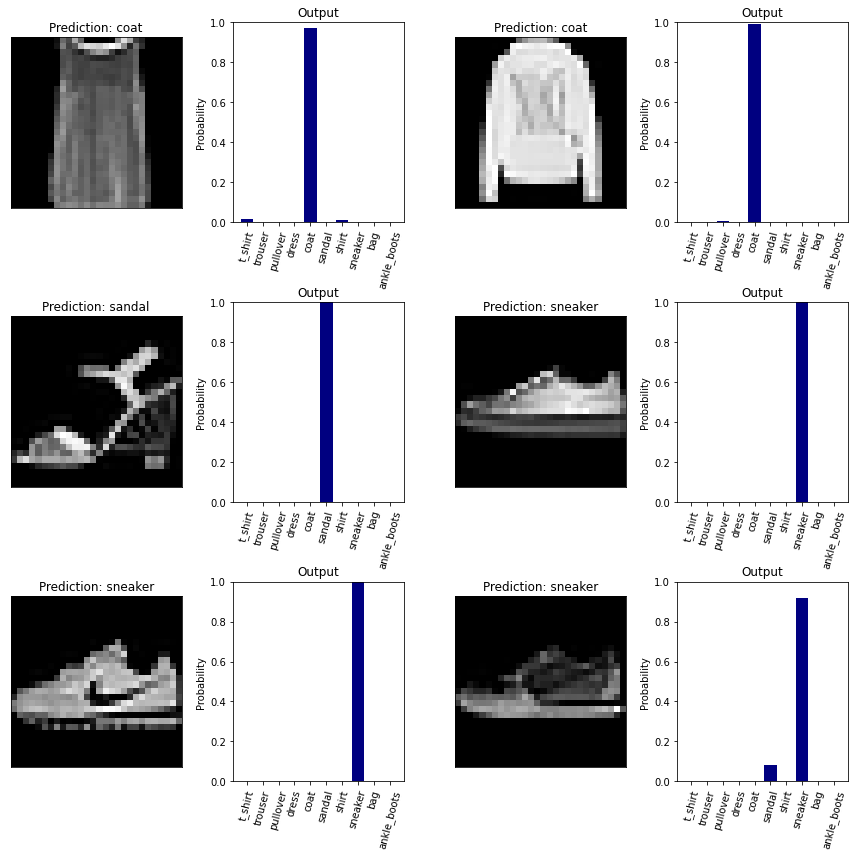

In [14]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
predictAndPlotAndShowOutput(modelFullyConnected, x_test_full_connected, y_test_full_connected, LABEL_NAMES)

### Trainingsverlauf

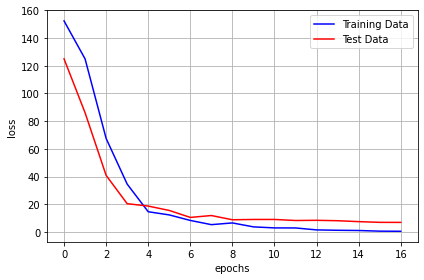

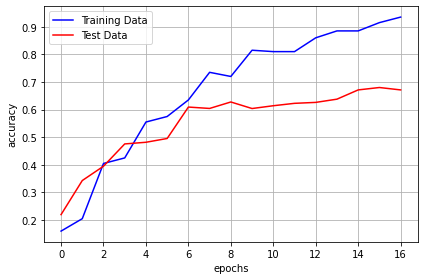

In [15]:
# plotten
epochs = np.arange(epoch)
plt.plot(epochs, train_losses_fully_con, label = 'Training Data', color ='blue')
plt.plot(epochs, test_losses_fully_con, label = 'Test Data', color ='red')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(epochs, train_accuracies_fully_con, label = 'Training Data', color ='blue')
plt.plot(epochs, test_accuracies_fully_con, label = 'Test Data', color ='red')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Convolutional Neural Networks

### Imports

In [16]:
#benötigte imports
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.callbacks import Callback
import tensorflow as tf
from tensorflow.python.eager import context
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import gzip
import os
import numpy as np
from keras.optimizers import Adam, SGD
import sys



### multithreading Einstellungen

In [17]:
# parallelization Einstellungen
_ = tf.Variable([1])
context._context = None
context._create_context()
num_threads = os.cpu_count()
tf.config.threading.set_inter_op_parallelism_threads(num_threads)
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
sys.excepthook = lambda *args: None

### Daten Laden

In [18]:
def load_mnist(kind='train', model_type ='convolutional'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(os.getcwd(),
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(os.getcwd(),
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
    #wenn ein convolutional model, dann lese daten in form von 28x28 Matrix ein
    if model_type == 'convolutional':
        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                                offset=16).reshape(len(labels), 28, 28)#.reshape(len(labels), 784)
    #sonsts lese daten in 784 Vektor ein        
    elif model_type == 'fully_connected':
        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [19]:
x_train_conv, y_train_conv = load_mnist(kind='train', model_type ='convolutional')
x_test_conv, y_test_conv = load_mnist(kind='t10k', model_type ='convolutional')
x_train_conv = np.expand_dims(x_train_conv, -1)
x_test_conv = np.expand_dims(x_test_conv, -1)

### Funktion zum Trainieren des Netzwerks, mit Rückgabe der Testgenauigkeit nach jedem Step

In [20]:

# erstelle Klasse mit benutzerdefinierten Aktionen, die während des trainings ausgeführt werden sollen
class TrainMetricsCallback(Callback):
    def __init__(self, x_test=None, y_test=None):
        super(TrainMetricsCallback, self).__init__()
        # listen zum speichern der accuracy und losses auf dem Test und dem Trainingsdatenset nach jeder epoch
        self.train_losses = []
        self.train_accuracies = []
        self.test_losses = []
        self.test_accuracies = []
        self.x_test = x_test
        self.y_test = y_test

    # Am ende der epoch füge die accuracy und loss werte zu den Listen hinzu
    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.train_accuracies.append(logs.get('accuracy'))
        
        if self.x_test is not None and self.y_test is not None:
            # Auswerten der modells für das Trainigsdatenset
            loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
            self.test_losses.append(loss)
            self.test_accuracies.append(accuracy)
# Methode um nach jdem Trainingsschritt die accuracy und loss sowohl auf dem Testdatenset als auch
# auf den Trainingsdatenset als Liste zurückzugeben
def train_and_get_metrics(model, x_train, y_train, x_test=None, y_test=None, epochs=1, batch_size = 128):
    train_metrics_callback = TrainMetricsCallback(x_test, y_test)
    model.fit(x_train, y_train, epochs=epochs, callbacks=[train_metrics_callback],  batch_size=batch_size)
    
    # geben die accuracies und losses für die Test und Trainingsdaten zurück
    return train_metrics_callback.train_losses, train_metrics_callback.train_accuracies, \
           train_metrics_callback.test_losses, train_metrics_callback.test_accuracies, model

### Convolutional Modell erstellen

In [21]:
def createConvModel():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=(28, 28,1)))
  model.add(tf.keras.layers.Conv2D(16, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train_conv.shape[1:]))
  model.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train_conv.shape[1:]))
  model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('elu'))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  return model
model_conv = createConvModel()

### Erstelltes Modell kompilieren und trainieren

In [22]:
no_epochs=17
batch_size=30
nr_train_data = 60000   #kleiner als 60000
optimizer = Adam(learning_rate=1e-3)
model_conv.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
tf.keras.backend.clear_session()
train_losses_conv, train_accuracies_conv, test_losses_conv, test_accuracies_conv, model_conv = train_and_get_metrics(model_conv, x_train_conv[:nr_train_data], y_train_conv[:nr_train_data], x_test_conv, y_test_conv,  epochs=no_epochs,  batch_size=batch_size)


Epoch 1/17


1999/2000 [============================>.] - ETA: 0s - loss: 0.3900 - sparse_categorical_accuracy: 0.8581

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7fd9a53b2680>
Traceback (most recent call last):
  File "/home/moritz/anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/polymorphic_function/monomorphic_function.py", line 184, in __del__
    context.remove_function(self.name)
  File "/home/moritz/anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 2707, in remove_function
    context().remove_function(name)
  File "/home/moritz/anaconda3/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 1361, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_Dataset_map_grab_batch_24501'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7fd9a53b2680>
Traceback (most recent call last):
  File "/home/moritz/anaconda3/lib/python3.7/site-packages/tensorflow/p

2000/2000 [==============================] - 29s 14ms/step - loss: 0.3900 - sparse_categorical_accuracy: 0.8582
Epoch 2/17
2000/2000 [==============================] - 29s 15ms/step - loss: 0.2735 - sparse_categorical_accuracy: 0.8983
Epoch 3/17
2000/2000 [==============================] - 30s 15ms/step - loss: 0.2268 - sparse_categorical_accuracy: 0.9152
Epoch 4/17
2000/2000 [==============================] - 28s 14ms/step - loss: 0.1945 - sparse_categorical_accuracy: 0.9266
Epoch 5/17
2000/2000 [==============================] - 28s 14ms/step - loss: 0.1704 - sparse_categorical_accuracy: 0.9352
Epoch 6/17
2000/2000 [==============================] - 28s 14ms/step - loss: 0.1429 - sparse_categorical_accuracy: 0.9458
Epoch 7/17
2000/2000 [==============================] - 28s 14ms/step - loss: 0.1268 - sparse_categorical_accuracy: 0.9518
Epoch 8/17
2000/2000 [==============================] - 28s 14ms/step - loss: 0.1047 - sparse_categorical_accuracy: 0.9600
Epoch 9/17
2000/2000 [=====

In [23]:
# Konvertiert das 1D-Array in ein 2D-Array, das zum Plotten der Ziffer verwendet wird.
def to2DArray(vektor):
    matrix = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            matrix[i, j] = vektor[i*28 + j]
            
    return matrix

def predictAndPlotAndShowOutput(modell, testdaten, test_verifikationsdaten, label=False, convolutional = False):
    daten_verfügbar = range(len(testdaten))
    daten_zum_plotten = np.random.choice(daten_verfügbar, size = 6, replace=False)
    if label:
        fig, ax = plt.subplots(3, 4, figsize=(12, 12))
    else:
        fig, ax = plt.subplots(3, 4, figsize=(12, 9))
    for j in range(3):
        for i in range(2):
            vorhersage_verteilung = modell.predict(np.array([testdaten[daten_zum_plotten[j*2+i]]]))
            vorhersage = np.argmax(vorhersage_verteilung)
            confidence = np.max(vorhersage)
            if convolutional == False:
                ax[j, 2*i].imshow(to2DArray(testdaten[daten_zum_plotten[j*2+i]]), cmap='gray', interpolation='none')
            else:
                ax[j, 2*i].imshow(testdaten[daten_zum_plotten[j*2+i]], cmap='gray', interpolation='none')
    
            #+ ", confidence: " +str(round(confidence,3)))
            ax[j, 2*i].axes.get_xaxis().set_visible(False)
            ax[j, 2*i].axes.get_yaxis().set_visible(False)
            ax[j, 2*i+1].bar(np.arange(10), vorhersage_verteilung[0], color = 'navy')
            
            ax[j, 2*i+1].set_ylabel("Probability")
            ax[j, 2*i+1].set_ylim(0,1)
            ax[j, 2*i+1].set_title("Output")

            if label:
                ax[j, 2*i+1].set_xticks(np.arange(10))
                ax[j, 2*i+1].set_xticklabels(label,rotation = 75)
                ax[j, 2*i].set_title("Prediction: "+label[vorhersage])
            else:
                ax[j, 2*i].set_title("Prediction: "+str(vorhersage))
                ax[j, 2*i+1].set_xticks(np.arange(10))
                ax[j, 2*i+1].set_xlabel("Digit")
    if label:
        plt.subplots_adjust(hspace=0.4, wspace=0.3)

  
    plt.tight_layout()
    plt.savefig("output.png", dpi=500)
    
    plt.subplots_adjust(hspace=0.4, wspace = 0.3)

1/1 [==============================] - 0s 15ms/step


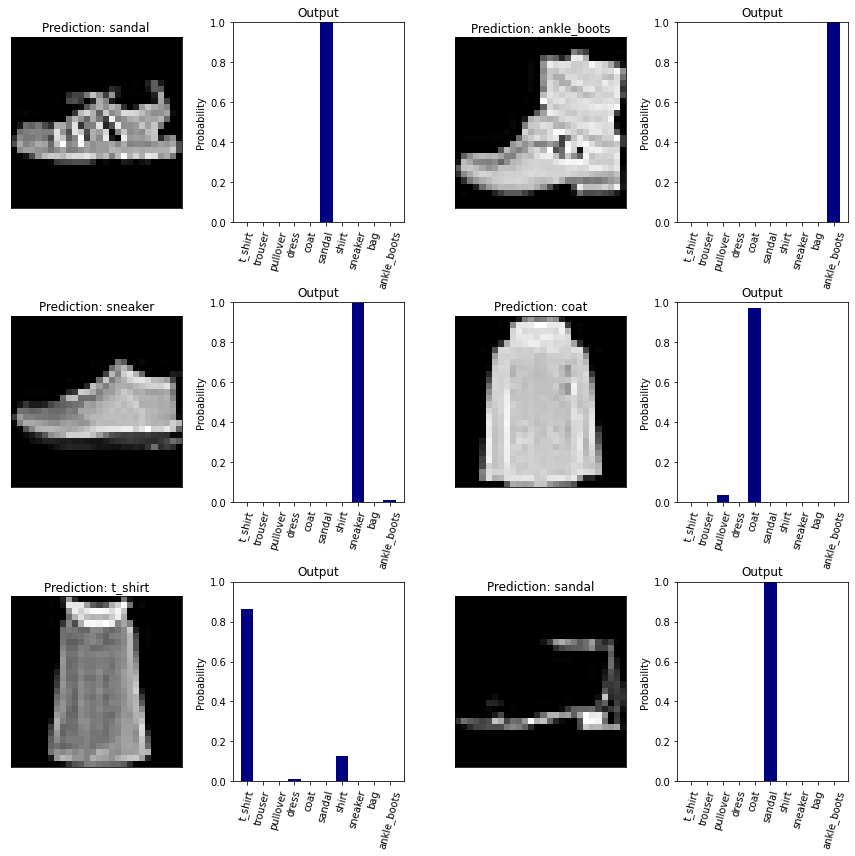

In [24]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
predictAndPlotAndShowOutput(model_conv, x_test_conv, y_test_conv, label=LABEL_NAMES, convolutional = True)

### Fully Connected Modell erstellen

In [25]:
def createFullyConnectedModel():
    model = tf.keras.models.Sequential()
    model.add(Dense(600, activation='relu', input_shape=(784,),name = "input_layer"))
    model.add(Dense(400, activation='relu',  name = "hidden_layer_1"))
    model.add(Dense(100, activation='relu',  name = "hidden_layer_2"))
    model.add(Dense(10, activation = 'softmax', name = "output_layer"))
    return model
model_fully_connected = createFullyConnectedModel()

In [26]:
x_train_full_connected, y_train_full_connected = load_mnist(kind='train', model_type ='fully_connected')
x_test_full_connected, y_test_full_connected = load_mnist(kind='t10k', model_type ='fully_connected')
x_train_full_connected = np.expand_dims(x_train_full_connected, -1)
x_test_full_connected = np.expand_dims(x_test_full_connected, -1)

### Training des Fully Connected Modells

In [27]:
optimizer = Adam(learning_rate=1e-3)
tf.keras.backend.clear_session()
model_fully_connected.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_losses_fully_con, train_accuracies_fully_connected, test_losses_fully_connected, test_accuracies_fully_connected, model_fully_connected = train_and_get_metrics(model_fully_connected, x_train_full_connected[:nr_train_data], y_train_full_connected[:nr_train_data], x_test_full_connected, y_test_full_connected,  epochs=no_epochs,  batch_size=batch_size)


Epoch 1/17
2000/2000 [==============================] - 8s 4ms/step - loss: 1.4841 - accuracy: 0.7915
Epoch 2/17
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4645 - accuracy: 0.8375
Epoch 3/17
2000/2000 [==============================] - 8s 4ms/step - loss: 0.4214 - accuracy: 0.8515
Epoch 4/17
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3890 - accuracy: 0.8613
Epoch 5/17
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3759 - accuracy: 0.8658
Epoch 6/17
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3591 - accuracy: 0.8709
Epoch 7/17
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3491 - accuracy: 0.8756
Epoch 8/17
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3412 - accuracy: 0.8794
Epoch 9/17
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3225 - accuracy: 0.8855
Epoch 10/17
2000/2000 [==============================] - 8s 4ms/step - loss: 0.322

### Vergleich Convolutional vs Fully connected   

### Feature detection des Convolutional Network

1/1 [==============================] - 0s 58ms/step


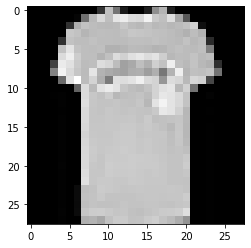

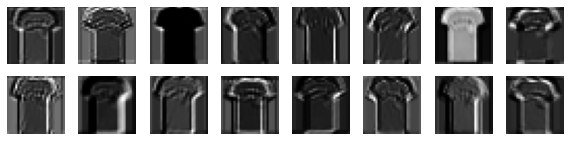

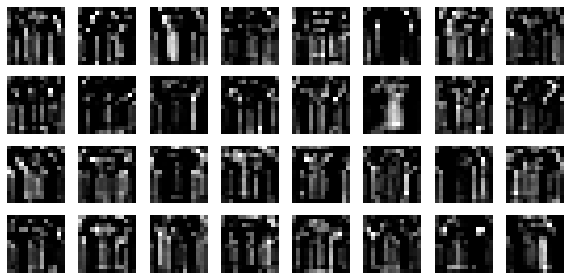

In [28]:

conv_layer_indices = [0,1]#,2]

# Lade ein Testbeispiel (z.B. x_test[0])
test_example = x_test_conv[19]

# Erstelle ein neues Modell, das die Zwischenergebnisse der ausgewählten Schichten ausgibt
conv_layers = [layer for layer in model_conv.layers if isinstance(layer, tf.keras.layers.Conv2D)]
layer_outputs = [conv_layers[i].output for i in conv_layer_indices]
activation_model = tf.keras.models.Model(inputs=model_conv.input, outputs=layer_outputs)

# Nutze das Testbeispiel, um die Zwischenergebnisse zu erhalten
activations = activation_model.predict(np.expand_dims(test_example, axis=0))
plt.imshow(x_test_conv[19], cmap='gray')
# Plotte die Zwischenergebnisse

for i, activation in enumerate(activations):
    plt.figure(figsize=(10, 10))
    num_filters = activation.shape[3]  # Anzahl der Filter für diesen Convolutional Layer
    num_plots = min(num_filters, 64)  # Höchstens 64 Plots
    for j in range(num_plots):
        plt.subplot(8, 8, j+1)
        plt.imshow(activation[0, :, :, j], cmap='gray')
        plt.axis('off')
    plt.show()

### Plotten der Filter

(5, 5, 1, 16)


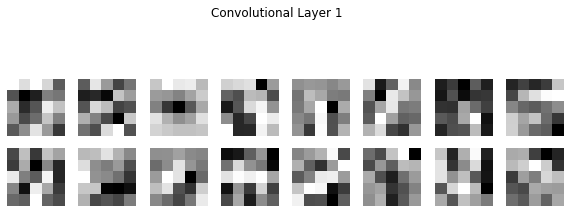

(5, 5, 16, 32)


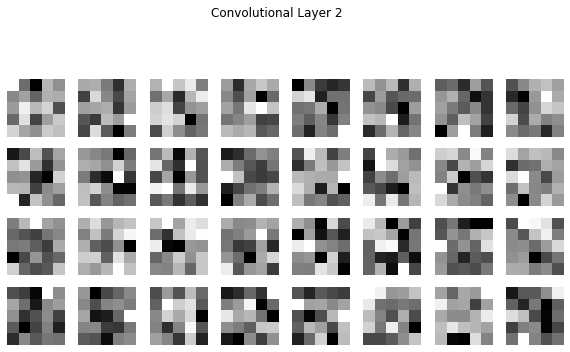

(5, 5, 32, 64)


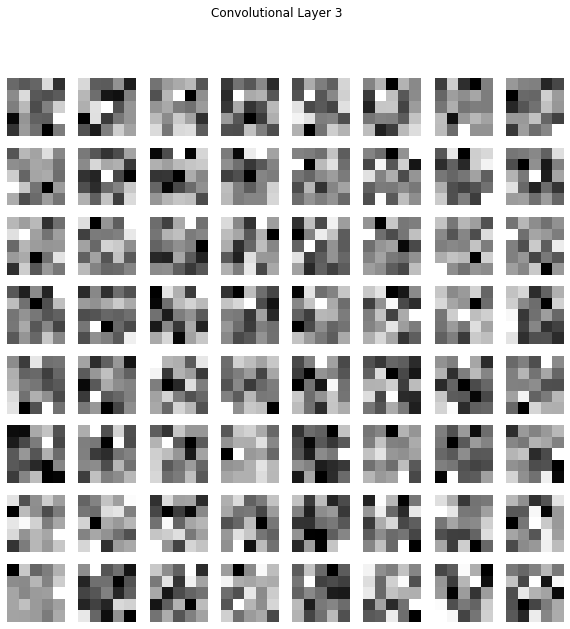

In [29]:
# Gewichtung der Konvolutionalschichten erhalten
conv_layers = [layer for layer in model_conv.layers if isinstance(layer, tf.keras.layers.Conv2D)]

# Filtern für jede Konvolutional-Schicht plotten
for i, layer in enumerate(conv_layers):
    weights = layer.get_weights()[0]
    print(weights.shape)
    
    # Anzahl der Filter in der aktuellen Schicht
    num_filters = weights.shape[3]
    
    # Anzahl der Subplots pro Zeile und Spalte
    n_cols = 8
    
    plt.figure(figsize=(10, 10))
    for j in range(num_filters):
        plt.subplot(8, 8, j+1)
        plt.imshow(weights[:, :, 0, j], cmap='gray')  # Angenommen, Graustufenfilter
        plt.axis('off')
    plt.suptitle(f'Convolutional Layer {i+1}')
    plt.show()

### Vergleich Optimizer Adam vs SGD

In [30]:
optimizer = SGD(learning_rate=1e-3)
model_conv_SGD = createConvModel()
model_conv_SGD.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
train_losses_conv_SGD, train_accuracies_conv_SGD, test_losses_conv_SGD, test_accuracies_conv_SGD, model_conv_SGD = train_and_get_metrics(model_conv_SGD, x_train_conv[:nr_train_data], y_train_conv[:nr_train_data], x_test_conv, y_test_conv,  epochs=no_epochs,  batch_size=batch_size)

Epoch 1/17
2000/2000 [==============================] - 28s 14ms/step - loss: 0.6331 - sparse_categorical_accuracy: 0.7853
Epoch 2/17
2000/2000 [==============================] - 27s 14ms/step - loss: 0.4268 - sparse_categorical_accuracy: 0.8512
Epoch 3/17
2000/2000 [==============================] - 27s 14ms/step - loss: 0.3747 - sparse_categorical_accuracy: 0.8682
Epoch 4/17
2000/2000 [==============================] - 27s 14ms/step - loss: 0.3437 - sparse_categorical_accuracy: 0.8796
Epoch 5/17
2000/2000 [==============================] - 28s 14ms/step - loss: 0.3213 - sparse_categorical_accuracy: 0.8876
Epoch 6/17
2000/2000 [==============================] - 28s 14ms/step - loss: 0.3043 - sparse_categorical_accuracy: 0.8936
Epoch 7/17
2000/2000 [==============================] - 28s 14ms/step - loss: 0.2907 - sparse_categorical_accuracy: 0.8975
Epoch 8/17
2000/2000 [==============================] - 28s 14ms/step - loss: 0.2783 - sparse_categorical_accuracy: 0.9024
Epoch 9/17
2000/

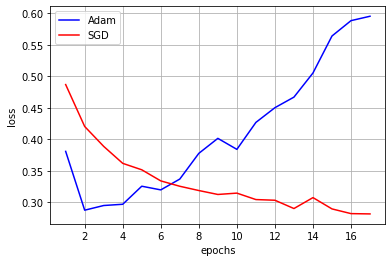

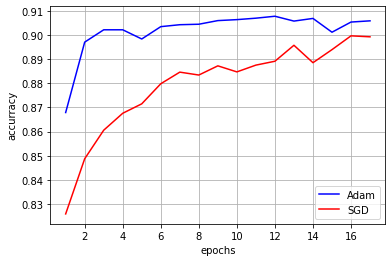

In [31]:
epochs = np.arange(1,no_epochs+1)
plt.plot(epochs,test_losses_conv, label = 'Adam', color = 'blue')
plt.plot(epochs,test_losses_conv_SGD, label = 'SGD', color = 'red')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()

plt.plot(epochs,test_accuracies_conv, label = 'Adam', color = 'blue')
plt.plot(epochs,test_accuracies_conv_SGD, label = 'SGD', color = 'red')
plt.xlabel("epochs")
plt.ylabel("accurracy")
plt.grid()
plt.legend()
plt.show()

## Handwritten Digits

### Daten Einlesen

In [32]:
def readData(train_size, test_size):
    # Lade den MNIST-Datensatz
    data=np.load("DigitRecognition/mnist.npz")
    x_train=data['x_train']
    y_train=data['y_train']
    x_test=data['x_test']
    y_test=data['y_test']
    #(x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Überprüfe, ob train_size oder test_size nicht größer als die Anzahl der Datensätze ist
    if train_size > len(x_train) :
        print("Fehler: train_size überschreitet Datenmenge von "+str(len(x_train)))
        sys.exit() 
    if test_size > len(x_test) :
        print("Fehler: test_size überschreitet Datenmenge von "+str(len(x_test)))
        sys.exit() 

    # Wähle zufällige Indizes für Trainingsdaten
    train_indices = random.sample(range(len(x_train)), train_size)
    # Wähle zufällige Indizes für Testdaten
    test_indices = random.sample(range(len(x_test)), test_size)
    
    # Extrahiere die ausgewählten Trainingsdaten und Testdaten
    train_data = x_train[train_indices].reshape(train_size, -1) / 255.0
    verify_train_data = y_train[train_indices]
    test_data = x_test[test_indices].reshape(test_size, -1) / 255.0
    verify_test_data = y_test[test_indices]

    return train_data, verify_train_data, test_data, verify_test_data

In [33]:
x_train_digits, y_train_digits, x_test_digits, y_test_digits = readData(60000, 1000)
x_train_digits = x_train_digits.reshape(60000, 28, 28)
x_test_digits = x_test_digits.reshape(1000, 28, 28)
x_train_digits = np.expand_dims(x_train_digits, -1)
x_test_digits = np.expand_dims(x_test_digits, -1)

### Netz Trainieren

In [34]:
tf.keras.backend.clear_session()
model_conv_digits = createConvModel()
no_epochs=17
batch_size=20
optimizer = Adam(learning_rate=1e-3)
model_conv_digits.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
train_losses_conv_digits, train_accuracies_conv_digits, test_losses_conv_digits, test_accuracies_conv_digits, model_conv_digits = train_and_get_metrics(model_conv_SGD, x_train_digits[:nr_train_data], y_train_digits[:nr_train_data], x_test_digits, y_test_digits,  epochs=no_epochs,  batch_size=batch_size)

Epoch 1/17
3000/3000 [==============================] - 28s 9ms/step - loss: 0.2319 - sparse_categorical_accuracy: 0.9333
Epoch 2/17
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0898 - sparse_categorical_accuracy: 0.9741
Epoch 3/17
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0669 - sparse_categorical_accuracy: 0.9806
Epoch 4/17
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9838
Epoch 5/17
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9868
Epoch 6/17
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0403 - sparse_categorical_accuracy: 0.9887
Epoch 7/17
3000/3000 [==============================] - 29s 10ms/step - loss: 0.0359 - sparse_categorical_accuracy: 0.9902
Epoch 8/17
3000/3000 [==============================] - 28s 9ms/step - loss: 0.0324 - sparse_categorical_accuracy: 0.9915
Epoch 9/17
3000/30

### Plotten des Trainingsprozess

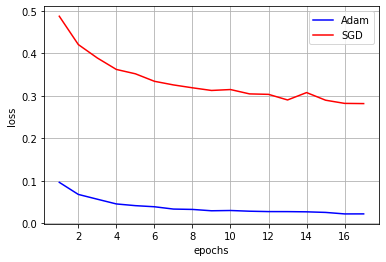

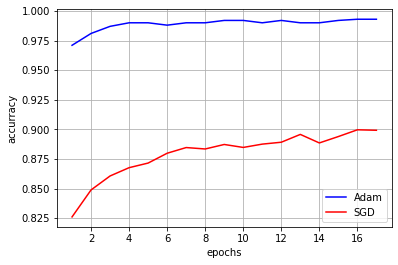

In [35]:
epochs = np.arange(1,no_epochs+1)
plt.plot(epochs,test_losses_conv_digits, label = 'Adam', color = 'blue')
plt.plot(epochs,test_losses_conv_SGD, label = 'SGD', color = 'red')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()

plt.plot(epochs,test_accuracies_conv_digits, label = 'Adam', color = 'blue')
plt.plot(epochs,test_accuracies_conv_SGD, label = 'SGD', color = 'red')
plt.xlabel("epochs")
plt.ylabel("accurracy")
plt.grid()
plt.legend()
plt.show()

### Output der Filter plotten

1/1 [==============================] - 0s 59ms/step


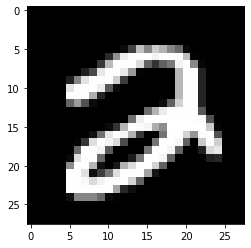

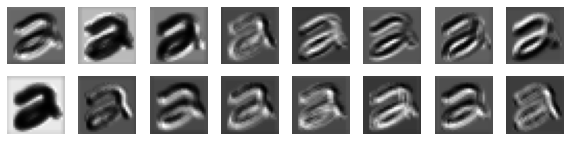

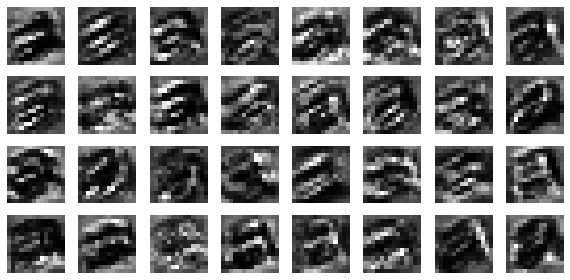

In [36]:

conv_layer_indices = [0,1]

# Lade ein Testbeispiel (z.B. x_test[0])
test_example = x_test_digits[6]

# Erstelle ein neues Modell, das die Zwischenergebnisse der ausgewählten Schichten ausgibt
conv_layers = [layer for layer in model_conv_digits.layers if isinstance(layer, tf.keras.layers.Conv2D)]
layer_outputs = [conv_layers[i].output for i in conv_layer_indices]
activation_model = tf.keras.models.Model(inputs=model_conv_digits.input, outputs=layer_outputs)

# Nutze das Testbeispiel, um die Zwischenergebnisse zu erhalten
activations = activation_model.predict(np.expand_dims(test_example, axis=0))
plt.imshow(x_test_digits[6], cmap='gray')
# Plotte die Zwischenergebnisse

for i, activation in enumerate(activations):
    plt.figure(figsize=(10, 10))
    num_filters = activation.shape[3]  # Anzahl der Filter für diesen Convolutional Layer
    num_plots = min(num_filters, 64)  # Höchstens 64 Plots
    for j in range(num_plots):
        plt.subplot(8, 8, j+1)
        plt.imshow(activation[0, :, :, j], cmap='gray')
        plt.axis('off')
    plt.show()

### Plotten der Filter

(5, 5, 1, 16)


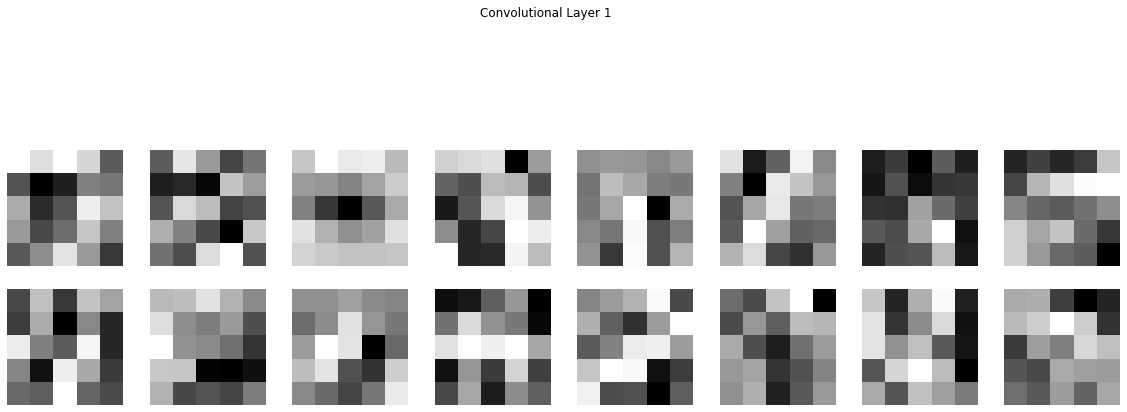

(5, 5, 16, 32)


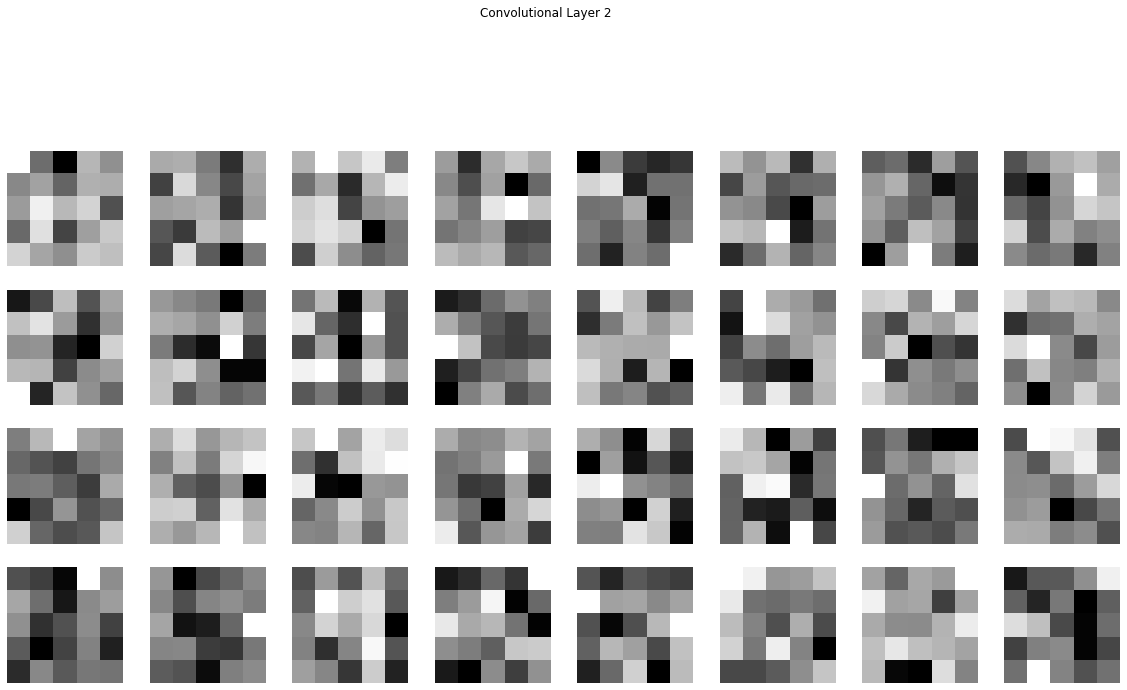

(5, 5, 32, 64)


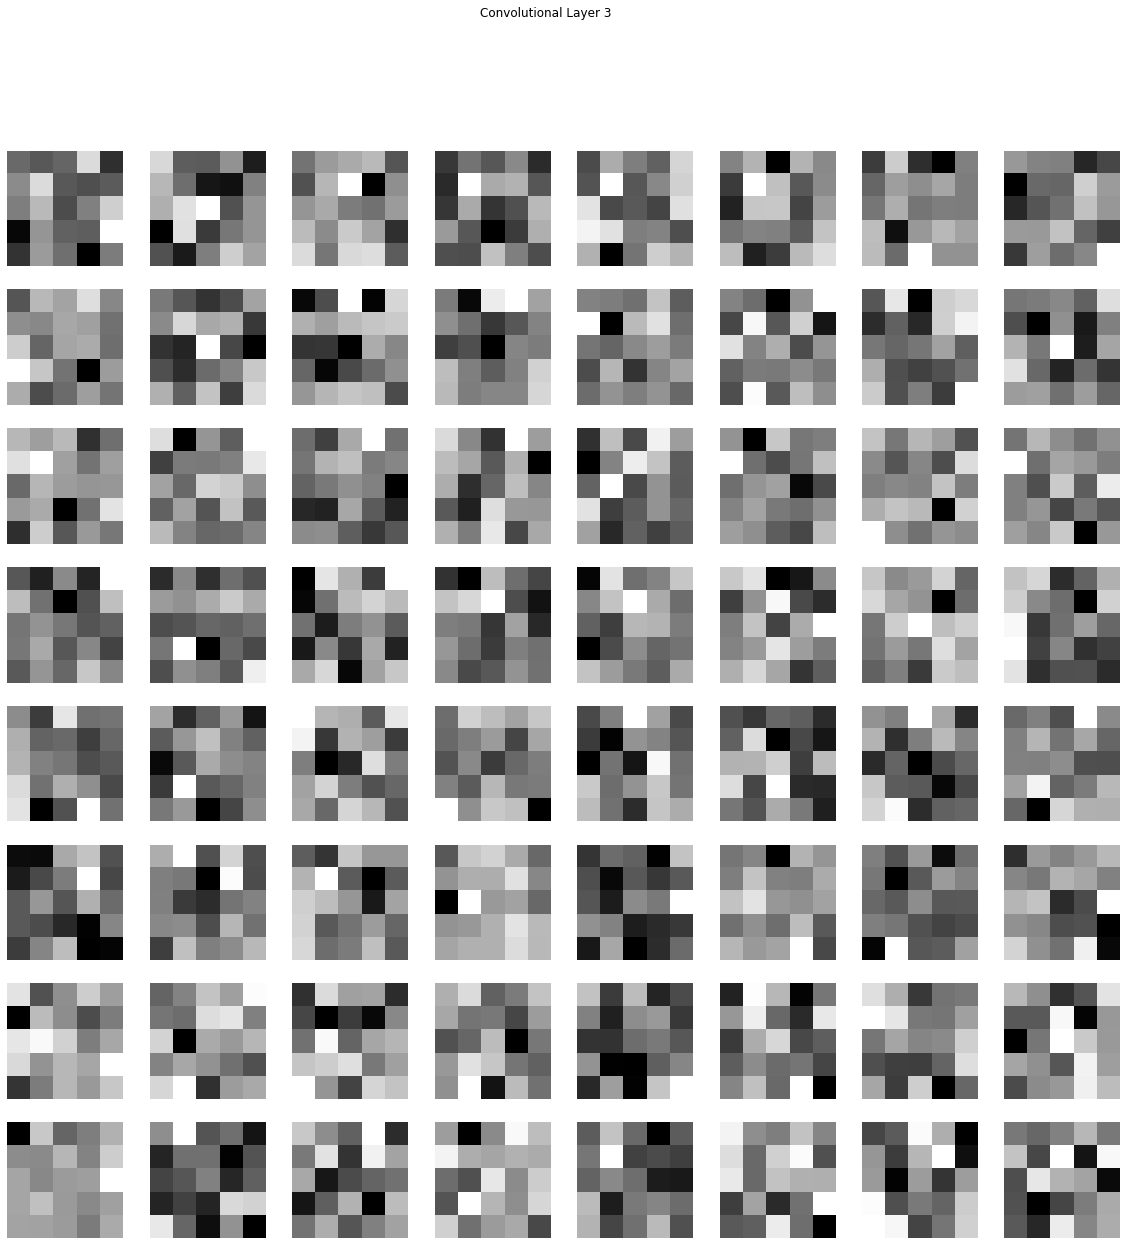

In [37]:
# Gewichtung der Konvolutionalschichten erhalten
conv_layers = [layer for layer in model_conv.layers if isinstance(layer, tf.keras.layers.Conv2D)]

# Filtern für jede Konvolutional-Schicht plotten
for i, layer in enumerate(conv_layers):
    weights = layer.get_weights()[0]
    print(weights.shape)
    
    # Anzahl der Filter in der aktuellen Schicht
    num_filters = weights.shape[3]
    
    # Anzahl der Subplots pro Zeile und Spalte
    n_cols = 8
    
    plt.figure(figsize=(20, 20))
    for j in range(num_filters):
        plt.subplot(8, 8, j+1)
        plt.imshow(weights[:, :, 0, j], cmap='gray')  # Angenommen, Graustufenfilter
        plt.axis('off')
    plt.suptitle(f'Convolutional Layer {i+1}')
    plt.show()